In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from relu_solver import Approximate_2_Layer_ReLU
from relu_utils import squared_loss, classifcation_accuracy

In [2]:
# generate toy data trying to fit noisy data to cosine
data = pd.read_csv("test_data/winequality-red.csv", delimiter=";")
X = np.array(data)[:,:11]
y = np.array(data.quality)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_train, d = X_train.shape
n_test = X_test.shape[0]

print(f"n train = {n_train}")
print(f"n test = {n_test}")

m = 10

n train = 1279
n test = 320


NONCONVEX PROBLEM WEIGHTS:
Train loss: 339.5
Train accuracy: 0.5934323690383112
Test loss: 91.5
Test accuracy: 0.521875


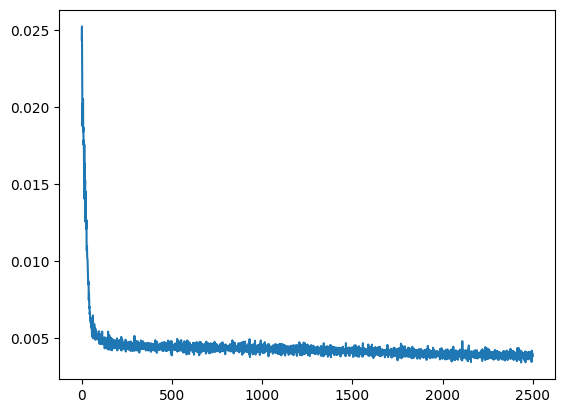

In [3]:
# TODO still need to optimize lr and batch_size

# Try to use GPU 
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training params
lr = 1e-3
batch_size = 2 ** 8
epochs = 500

# Network
MLP = nn.Sequential(nn.Linear(d, m),
                    nn.ReLU(),
                    nn.Linear(m, np.max(y)+1)).to(dev)

# Train/Test data to torch
X_train_torch = torch.as_tensor(X_train, dtype=torch.float32)
y_train_torch = torch.as_tensor(y_train, dtype=torch.float32)
X_test_torch = torch.as_tensor(X_test, dtype=torch.float32)
y_test_torch = torch.as_tensor(y_test, dtype=torch.float32)
trainset = TensorDataset(X_train_torch, y_train_torch)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Optimizer and loss
optim = torch.optim.Adam(MLP.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

# Train
losses = []
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}', end='\r', flush=True)
    for sample, label in iter(trainloader):

        # Move to device
        sample = sample.to(dev)
        label = label.to(dev)

        # predict 
        pred = MLP(sample)

        # Back prop
        loss = loss_func(pred, label.long())
        loss.backward()
        optim.step()
        optim.zero_grad()
        losses.append(float(loss) / batch_size)

# Show trianing curve 
plt.plot(losses)

# Prediction
with torch.no_grad():
    y_hat_train = np.argmax(MLP(X_train_torch.to(dev)).to('cpu').numpy(), axis=-1)
    y_hat_test = np.argmax(MLP(X_test_torch.to(dev)).to('cpu').numpy(), axis=-1)

# Show results
print("NONCONVEX PROBLEM WEIGHTS:")
print(f"Train loss: {squared_loss(y_hat_train, y_train)}")
print(f"Train accuracy: {classifcation_accuracy(y_hat_train, y_train)}")
print(f"Test loss: {squared_loss(y_hat_test, y_test)}")
print(f"Test accuracy: {classifcation_accuracy(y_hat_test, y_test)}")

Solver doesn't converge well... Things needing fixing right now: 

- How to choose m, P_S?
- How to choose parameters $\rho$, step=$\gamma_{\alpha}$, $\beta$? 
- Converting from optimal weights $v, w$ to $u, \alpha$. Currently loss during training is consistently high but gets lower when calling .predict
- Runtime warning - divide by zero in optimizer. need to figure out why / fix

In [4]:
# SOLVE THE CONVEX PROBLEM

params = dict(m = 10,
            P_S = 20,
            rho = 0.0001,
            step = 0.00001,
            beta = 0.0001,
            bias = True,
            seed = 364,
            standardize_data = False,
)
max_iter = 100

# using admm solver
solver = Approximate_2_Layer_ReLU(**params, optimizer="admm")

solver.optimize(X_train, y_train, max_iter=max_iter, verbose=False)

print("ADMM SOLVER PERFORMANCE:")
y_hat_train = solver.predict(X_train, weights="C-ReLU")
y_hat_test = solver.predict(X_test, weights="C-ReLU")
print(f"Train loss: {squared_loss(y_hat_train, y_train)}")
print(f"Train accuracy: {classifcation_accuracy(y_hat_train, y_train)}")
print(f"Test loss: {squared_loss(y_hat_test, y_test)}")
print(f"Test accuracy: {classifcation_accuracy(y_hat_test, y_test)}")

# compare to cvxpy solver with same random seed
solver = Approximate_2_Layer_ReLU(**params, optimizer="cvxpy")

solver.optimize(X_train, y_train, max_iter=max_iter, verbose=False)

print("\nCVXPY SOLVER PERFORMANCE:")
y_hat_train = solver.predict(X_train, weights="C-ReLU")
y_hat_test = solver.predict(X_test, weights="C-ReLU")
print(f"Train loss: {squared_loss(y_hat_train, y_train)}")
print(f"Train accuracy: {classifcation_accuracy(y_hat_train, y_train)}")
print(f"Test loss: {squared_loss(y_hat_test, y_test)}")
print(f"Test accuracy: {classifcation_accuracy(y_hat_test, y_test)}")

ADMM SOLVER PERFORMANCE:
Train loss: 223.7803261888969
Train accuracy: 0.6395621579358874
Test loss: 61.74047757747313
Test accuracy: 0.596875

CVXPY SOLVER PERFORMANCE:
Train loss: 223.26428143421572
Train accuracy: 0.6348709929632526
Test loss: 62.27498473537075
Test accuracy: 0.59375


/Users/zachary/miniconda3/envs/cvx-env/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Text(0, 0.5, 'l-2 squared loss')

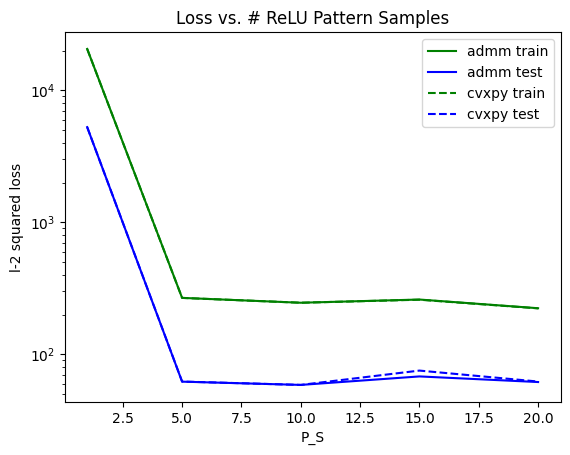

In [10]:
# GRID SEARCH ON P_S

params = dict(m = 10,
            rho = 0.0001,
            step = 0.00001,
            beta = 0.0001,
            bias = True,
            seed = 364,
            standardize_data = False,
)
max_iter = 100

P_S_vals = np.array([1, 5, 10, 15, 20])

admm_train_loss, cvxpy_train_loss, admm_test_loss, cvxpy_test_loss = [], [], [], []
admm_train_acc, cvxpy_train_acc, admm_test_acc, cvxpy_test_acc = [], [], [], []
admm_solve_time, cvxpy_solve_time = [], []

for P_S in P_S_vals:

    print(f"P_S = {P_S}")

    # using admm solver
    solver = Approximate_2_Layer_ReLU(**params, P_S = P_S, optimizer="admm")
    solver.optimize(X_train, y_train, max_iter=max_iter, verbose=False)
    y_hat_train = solver.predict(X_train, weights="C-ReLU")
    y_hat_test = solver.predict(X_test, weights="C-ReLU")
    admm_train_loss.append(squared_loss(y_hat_train, y_train))
    admm_test_loss.append(squared_loss(y_hat_test, y_test))
    admm_train_acc.append(classifcation_accuracy(y_hat_train, y_train))
    admm_test_acc.append(classifcation_accuracy(y_hat_test, y_test))
    admm_solve_time.append(solver.get_metrics()['solve_time'])

    # compare to cvxpy solver with same random seed
    solver = Approximate_2_Layer_ReLU(**params, P_S = P_S, optimizer="cvxpy")
    solver.optimize(X_train, y_train, max_iter=max_iter, verbose=False)
    y_hat_train = solver.predict(X_train, weights="C-ReLU")
    y_hat_test = solver.predict(X_test, weights="C-ReLU")
    cvxpy_train_loss.append(squared_loss(y_hat_train, y_train))
    cvxpy_test_loss.append(squared_loss(y_hat_test, y_test))
    cvxpy_train_acc.append(classifcation_accuracy(y_hat_train, y_train))
    cvxpy_test_acc.append(classifcation_accuracy(y_hat_test, y_test))
    cvxpy_solve_time.append(solver.get_metrics()['solve_time'])

plt.subplot(3,1,1)
plt.semilogy(P_S_vals, np.array(admm_train_loss), 'g', label="admm train")
plt.semilogy(P_S_vals, np.array(admm_test_loss), 'b', label="admm test")
plt.semilogy(P_S_vals, np.array(cvxpy_train_loss), 'g--', label="cvxpy train")
plt.semilogy(P_S_vals, np.array(cvxpy_test_loss), 'b--', label="cvxpy test")
plt.legend()
plt.title("Losses")
plt.xlabel("P_S"); plt.ylabel("l-2 squared loss")
plt.subplot(3,1,2)
plt.semilogy(P_S_vals, np.array(admm_train_acc), 'g', label="admm train")
plt.semilogy(P_S_vals, np.array(admm_test_acc), 'b', label="admm test")
plt.semilogy(P_S_vals, np.array(cvxpy_train_acc), 'g--', label="cvxpy train")
plt.semilogy(P_S_vals, np.array(cvxpy_test_acc), 'b--', label="cvxpy test")
plt.title("Accuracies")
plt.xlabel("P_S"); plt.ylabel("classification accuracy")
plt.subplot(3,1,3)
plt.semilogy(P_S_vals, np.array(admm_solve_time), 'g', label="admm")
plt.semilogy(P_S_vals, np.array(cvxpy_solve_time), 'b', label="cvxpy")
plt.title("Solve time")
plt.legend()
plt.xlabel("P_S"); plt.ylabel("time (s)")

plt.suptitle("Performance of Convex ReLU Solver vs. # ReLU Pattern Samples")
